# Práctica Despliegue de Algoritmos

Ramón-Armand Laborda Moreu

## Objetivo

El principal objetivo es registrar las métricas de un modelo en MLFlow. Para centrarnos en ese cometido, reciclo el modelo aplicado en la práctica de NLP donde realicé un análisis de sentimiento a las opiniones publicadas en Amazon sobre una categoría de productos farmacéuticos. 

Para tener un hilo conductor se dividirá en 4 apartados principalmente:

1. Descarga y exploración del corpus
2. Preprocesado de texto
3. Modelo de análisis de Sentimiento
4. Reporte de métricas y conclusiones


## 1. Descarga y exploración del corpus

McAuley Lab tiene disponible una colección de opiniones de Amazon convertidas ya en datasets crudos con los que podemos trabajar sin la necesidad de diseñar el webscrapping.

En la siguiente página web: <href> https://amazon-reviews-2023.github.io/ </href> se puede descargar un dataset correspondiente a las opiniones o reseñas y otro relativo al metadato del producto o las características comerciales.

De entre todas las categorías disponibles descargamos y descomprimimos en formato json la relacionada con: "Health and Personal Care"

In [1]:
import requests
import gzip
import shutil

url = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Health_and_Personal_Care.jsonl.gz'
response = requests.get(url, stream=True)

with open('Health_and_Personal_Care.jsonl.gz', 'wb') as file:
        file.write(response.content)

Una vez descargado, descomprimimos el fichero .jsonl

In [2]:
with gzip.open('Health_and_Personal_Care.jsonl.gz', 'rb') as f_in:
    with open('Health_and_Personal_Care.jsonl', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

Para realizar un primer análisis exploratorio de la estructura del corpus, leemos el jsonl con pandas.

In [1]:
import pandas as pd

corpus_hcpc = pd.read_json("Health_and_Personal_Care.jsonl", lines = True)

In [2]:
corpus_hcpc.head(2)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,4,12 mg is 12 on the periodic table people! Mg f...,This review is more to clarify someone else’s ...,[],B07TDSJZMR,B07TDSJZMR,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2020-02-06 00:49:35.902,3,True
1,5,Save the lanet using less plastic.,Love these easy multitasking bleach tablets. B...,[],B08637FWWF,B08637FWWF,AEVWAM3YWN5URJVJIZZ6XPD2MKIA,2020-11-02 22:03:06.880,3,True


Según la documentación original del dataset, y teniendo en mente el algoritmo que queremos ejecutar, hay campos que carecen de objeto de estudio. Eliminamos por tanto, "images", "asin", "parent_asin", "user_id", "timestamp", "helpful_vote" por el momento.

Nos quedamos con las variables:

- rating: (float) Rating of the product (from 1.0 to 5.0).
- title: (str) Title of the user review.
- text: (str) Text body of the user review.
- verified_purchase: (bool) User purchase verification.

In [3]:
corpus_hcpc.shape

(494121, 10)

In [4]:
corpus_hcpc.verified_purchase.value_counts()

verified_purchase
True     445072
False     49049
Name: count, dtype: int64

El primer paso es reducir el corpus utilizando exclusivamente opiniones de perfiles verificados. De esta forma se pretende disminuir el tamaño y mitigar opiniones generadas por bots o personas sin verificar.

In [5]:
corpus_hcpc = corpus_hcpc[corpus_hcpc.verified_purchase]
print(corpus_hcpc.shape)

(445072, 10)


Basándome en experiencias personales previas, el título de una reseña suele sintetizar lo que posteriormente se escribe en el texto (si es que se desarrolla un texto. Muchas veces por tiempo solo se indica el motivo de una opinión en el título) creo conveniente concatenar los campos de título y texto.

In [6]:
corpus_hcpc["title_text"] = corpus_hcpc["title"] + " " + corpus_hcpc["text"]

Filtramos los campos objeto de estudio para disponer de un corpus con el que hacer un análisis exploratorio de los datos.

In [7]:
corpus_hcpc = corpus_hcpc[["rating", "title_text"]]

In [8]:
print("El corpus tiene la siguiente estructura: ", corpus_hcpc.shape)
print("Con las siguientes columnas: ", ", ".join(corpus_hcpc.columns))

El corpus tiene la siguiente estructura:  (445072, 2)
Con las siguientes columnas:  rating, title_text


### Cardinalidad del vocabulario

Usamos la libreria sklearn, tokenizamos y observamos cuales son las palabras únicas excluyendo stopwords.

Para ello lo primero será descargar un listado de stopwords en inglés de NLTK

In [10]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = list(stopwords.words('english'))
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ralamo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(corpus_hcpc['title_text'])

print("Cardinalidad del vocabulario: ", len(vectorizer.get_feature_names_out()))

Cardinalidad del vocabulario:  86140


Parece que hay muchas palabras distintas. Es posible que se deba a los productos y la variedad de vocabulario. En cualquier caso, quiero observar cual sería la cardinalidad lematizando para reducirla un poco.

In [20]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

lemmatizer = WordNetLemmatizer()

def lemmatize_text_nltk(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

lemmatized_corpus = [lemmatize_text_nltk(doc) for doc in corpus_hcpc['title_text']]

vectorizer = CountVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(lemmatized_corpus)

print("Cardinalidad del vocabulario: ", len(vectorizer.get_feature_names_out()))

Cardinalidad del vocabulario:  84809


Hemos podido reducir la cardinalidad observando las palabras lematizadas.

### Distribución de opiniones por número de estrellas

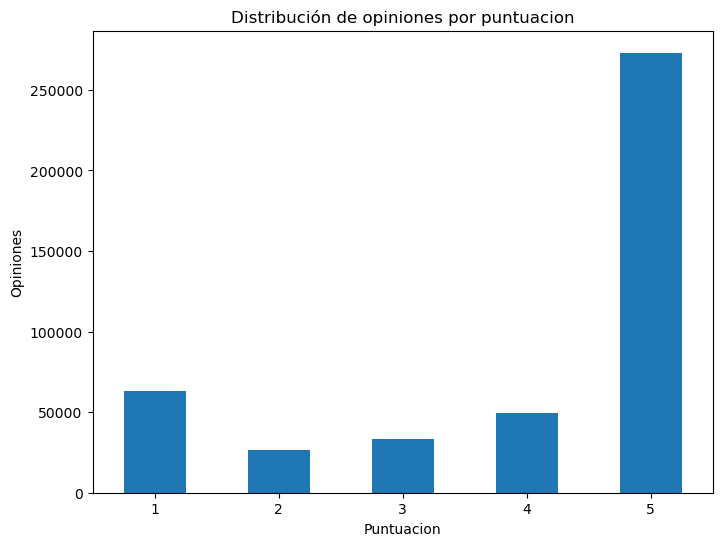

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
corpus_hcpc['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de opiniones por puntuacion')
plt.xlabel('Puntuacion')
plt.ylabel('Opiniones')
plt.xticks(rotation=0)
plt.show()

Observamos que, por lo general, las opinones han recibido 5 estrellas. El segundo grupo de opiniones más numeroso son las que tienen 1 estrella. Esto polariza casi de forma dicotómica el sentimiento del texto. Haber recibido 3 estrellas, realmente es estar conforme, en la escala likert podría representarse como "Ni de acuerdo ni en desacuerdo".

### Nº de opiniones positivas y negativas

En línea con lo mencionado en el punto anterior, para categorizar las opiniones en aquellas con sentimiento positivo y con sentimiento negativo, vamos a excluir todas aquellas opiniones que tomen valor 3. El 3 en la escala likert (sobre 5) refleja indiferencia, no ser ni bueno ni malo.

In [25]:
print("Hay ", len(corpus_hcpc[corpus_hcpc['rating'] >= 4]), " opiniones positivas")
print("Hay ", len(corpus_hcpc[corpus_hcpc['rating'] <= 2]), " opiniones negativas")

Hay  322307  opiniones positivas
Hay  89407  opiniones negativas


### N-grams más frecuentes

Al haber sacado la cardinalidad tanto de los tokens como de los lemas con la funcion de CountVectorizer, procedo a consultar los pares de palabras más frecuentes.

In [26]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words)
X = vectorizer.fit_transform(corpus_hcpc['title_text'])

ngram_freq = X.sum(axis=0).A1
ngram_freq_sorted = sorted(zip(vectorizer.get_feature_names_out(), ngram_freq), key=lambda x: x[1], reverse=True)

print("Top 15 bigrams más frecuentes:")
for ngram, freq in ngram_freq_sorted[:15]:
    print(f"{ngram}: {freq}")

Top 15 bigrams más frecuentes:
five stars: 41617
br br: 25398
great product: 21866
works great: 16465
easy use: 12392
works well: 10638
good product: 9935
waste money: 7830
four stars: 7827
stars great: 7065
highly recommend: 7003
good quality: 6807
one star: 6260
would recommend: 5662
great price: 5324


De entre los n-gramas pares más frecuentes observamos que la gran mayoría hacen referencia a sentimientos positivos, escasos a negativos (one star y waste money) y 1 que se mitigaría con un procesado relativo a dos saltos consecutivos de línea.

### Nube de palabras

Como la categoría es Healthcare, voy a dar un formato que usaría en una presentación de cara a mostrar resultados de una campaña OTC. (Productos médicos con venta "Over the Counter" que no necesitan prescripción médica).

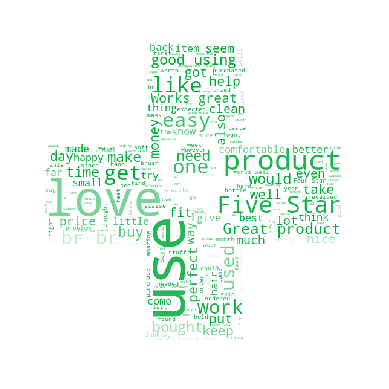

In [ ]:
from PIL import Image
import numpy as np
from wordcloud import ImageColorGenerator, WordCloud

text = " ".join(corpus_hcpc['title_text'])
wordcloud = WordCloud(width=800, height=400, stopwords=stop_words).generate(text)

mask = np.array(Image.open('cruz_farmacia.jpg'))
img_color = ImageColorGenerator(mask)

wordcloud = WordCloud(mask=mask, width=800, height=400, stopwords=stop_words, background_color='white').generate(text)

plt.imshow(wordcloud.recolor(color_func=img_color))
plt.axis('off')
plt.show()

Parece que las palabras más grandes que son las que tienen mayor frecuencia son "use" (relativa a la acción de utilizar los productos healthcare), "love", "five stars", "product", "easy", ...

### Visualización en 2 dimensiones de word-embeddings con word2vec

Escogemos 5 palabras y las representamos en el plano vectorial. Las palabras escogidas es una mezcla entre las más frecuentes y variadas para que no estén proximas.

- Love
- Star
- Bad
- Product
- Feel

Observamos que presentan distancia en los ejes. Vemos ahora cual es la respresentación en los vectores junto a las 10 palabras que en su contexto son similares.

Se nota que hace falta lematizar ya que hay palabras muy parecidas distribuidas al rededor de las palabras de referencia. Vamos a añadir color.

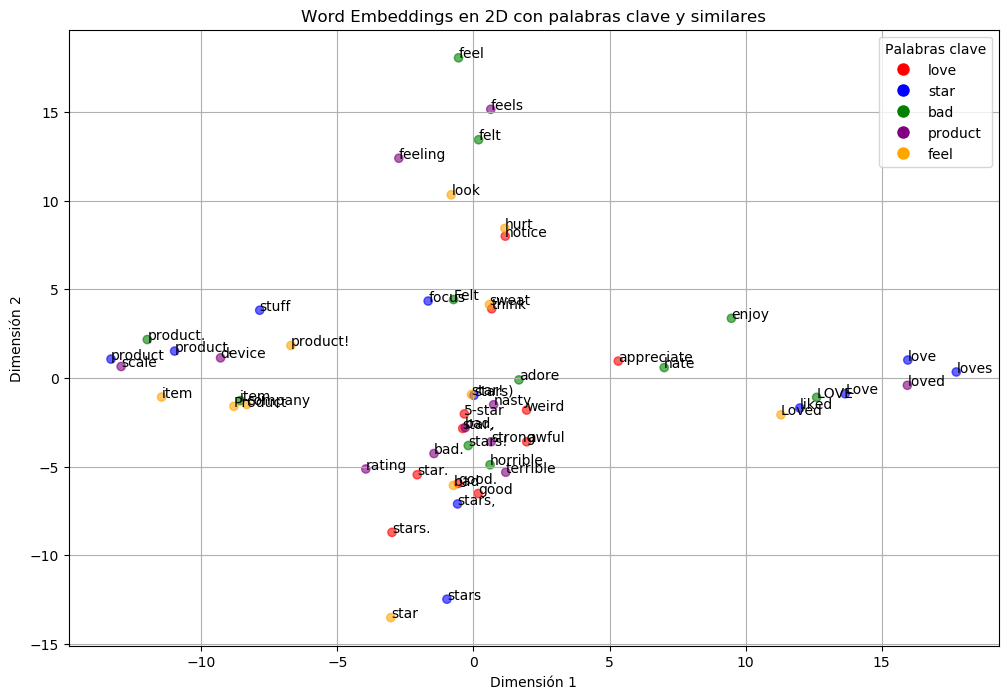

In [34]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

sentences = [title.split() for title in corpus_hcpc['title_text']]
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

words = ['love', 'star', 'bad', 'product', 'feel']

color_map = {
    'love': 'red',
    'star': 'blue',
    'bad': 'green',
    'product': 'purple',
    'feel': 'orange'
}

similar_words = []
word_colors = []

for word in words:
    similar = [word] + [sim_word for sim_word, _ in model.wv.most_similar(word, topn=10)]
    similar_words.extend(similar)
    word_colors.extend([color_map[word]] * len(similar))

similar_words = list(set(similar_words))
word_colors = [word_colors[similar_words.index(word)] for word in similar_words]

word_vectors = [model.wv[word] for word in similar_words]

pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_vectors)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=word_colors, alpha=0.6)

for i, word in enumerate(similar_words):
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]))

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[key], markersize=10) for key in color_map]
plt.legend(handles, color_map.keys(), title="Palabras clave", loc='upper right')

plt.title("Word Embeddings en 2D con palabras clave y similares")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.grid(True)
plt.show()

De esta forma queda mucho más claro el análisis vectorial donde se representan las palabras escogidas en sus ejes, junto con las 10 palabras con contexto similar con el mismo color.

### Conclusiones

- He observado una alta cardinalidad (que disminuye un poco si lematizamos) deribada de que existen datos muy variados. Además presumo que los productos añaden vocabulario adicional a las opiniones que en cierta medida se pueden repetir.
- La distribución de opiniones muestra un claro resultado determinado por 5 estrellas. Habrá que balancear las clases en el procesado del corpus.
- Las nubes de palabras en línea con la mayor frecuencia de 5 estrellas, indican palabras con sentimientos positivos.
- En el embedding vemos como la palabra star se posiciona en el eje cerca de la opinion real (good, terrible, wird, adore, ...)

(Presunción) Al tratarse de productos healthcare que han tenido que pasar por distintos ensayos, tratamientos y estados se espera un comportamiento positivo en el paciente lo que se resume en un sentimiento positivo generalizado.

## 2. Preprocesado del corpus

Para el procesado del corpus, voy a ejecutar distintas técnicas con las cuales se depure el corpus para prepararlo como input de un modelo. De forma independiente iré creando funciones que aplicaré consolidaré posteriormente en una única función.

Limpiamos el texto básico quitando espacios, convirtiendo a minúsculas, eliminamos signos de puntuación, caracteres extraños y textos con más de 3 caracteres seguidos iguales.

In [35]:
import re
import string
import unicodedata

def limpiar_corpus(text):
    
    text = text.lower()
    text = text.strip()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\b\w*(\w)\1{3,}\w*\b", "", text)

    return text

Para probar la correcta ejecución de las funciones, establecemos un texto de prueba procendente del corpus.

In [36]:
test_corpus = corpus_hcpc['title_text'][61]
print(test_corpus)

Really terrible soap, good for decoration only. Not happy. Not a fan of this, it's very nice to stare at or as decoration for the bathroom, the little cup they come on is cute and they look pretty, bu otherwise as far as soap goes it comes apart super easily. I would have to say 1 soap lasted me for about 2-3 times on the shower. Honestly I only took them to see if they were nice and they fall apart super easily also have a rough texture to them which is kind of strange considering they come apart really easily. The soap doesn't feel like soap at all though and doesn't make a lot of bubbles either it's just weird. In my opinion if you want it as a visual for your bathroom or just for decorating it's really fine but as far as soap goes, I'm sorry to say, one of the worst I've bought so far :s


In [37]:
limpiar_corpus(test_corpus)

'really terrible soap good for decoration only not happy not a fan of this its very nice to stare at or as decoration for the bathroom the little cup they come on is cute and they look pretty bu otherwise as far as soap goes it comes apart super easily i would have to say  soap lasted me for about  times on the shower honestly i only took them to see if they were nice and they fall apart super easily also have a rough texture to them which is kind of strange considering they come apart really easily the soap doesnt feel like soap at all though and doesnt make a lot of bubbles either its just weird in my opinion if you want it as a visual for your bathroom or just for decorating its really fine but as far as soap goes im sorry to say one of the worst ive bought so far s'

Eliminamos las stopword (palabras con poco o sin significado). Como nuestro objetivo es el análisis de sentimiento, las stopword negativas pueden anular un adjetivo positivo por lo que eliminarlas arrojaría un sentimiento inverso al esperado.

Voy a quitar del listado de stopwords las palabras negativas para que no se produzca dicho efecto.

In [38]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

negative_words = {
    "no",
    "not",
    "none",
    "neither",
    "never",
    "nobody",
    "nothing",
    "nowhere",
    "doesn't",
    "isn't",
    "wasn't",
    "shouldn't",
    "won't",
    "can't",
    "couldn't",
    "don't",
    "haven't",
    "hasn't",
    "hadn't",
    "aren't",
    "weren't",
    "wouldn't",
    "daren't",
    "needn't",
    "didn't",
    "without",
    "against",
    "negative",
    "deny",
    "reject",
    "refuse",
    "decline",
    "unhappy",
    "sad",
    "miserable",
    "hopeless",
    "worthless",
    "useless",
    "futile",
    "disagree",
    "oppose",
    "contrary",
    "contradict",
    "disapprove",
    "dissatisfied",
    "objection",
    "unsatisfactory",
    "unpleasant",
    "regret",
    "resent",
    "lament",
    "mourn",
    "grieve",
    "bemoan",
    "despise",
    "loathe",
    "detract",
    "abhor",
    "dread",
    "fear",
    "worry",
    "anxiety",
    "sorrow",
    "gloom",
    "melancholy",
    "dismay",
    "disheartened",
    "despair",
    "dislike",
    "aversion",
    "antipathy",
    "hate",
    "disdain"
}

stop_words = list(stopwords.words('english'))
stop_words = [element for element in stop_words if element not in negative_words]

def eliminar_stopwords(text):

    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]

    return ' '.join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ralamo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
eliminar_stopwords(limpiar_corpus(test_corpus))

'really terrible soap good decoration not happy not fan nice stare decoration bathroom little cup come cute look pretty bu otherwise far soap goes comes apart super easily would say soap lasted times shower honestly took see nice fall apart super easily also rough texture kind strange considering come apart really easily soap doesnt feel like soap though doesnt make lot bubbles either weird opinion want visual bathroom decorating really fine far soap goes im sorry say one worst ive bought far'

Pasamos ahora a una funcion de tokenización y lematización en una sola función ya que el objetivo es lematizar.

In [40]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def lematizar_corpus(text):

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

[nltk_data] Downloading package wordnet to /Users/ralamo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ralamo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ralamo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
print("Texto original:            ", test_corpus)
print("Texto limpio y lematizado: ", lematizar_corpus(eliminar_stopwords(limpiar_corpus(test_corpus))))

Texto original:             Really terrible soap, good for decoration only. Not happy. Not a fan of this, it's very nice to stare at or as decoration for the bathroom, the little cup they come on is cute and they look pretty, bu otherwise as far as soap goes it comes apart super easily. I would have to say 1 soap lasted me for about 2-3 times on the shower. Honestly I only took them to see if they were nice and they fall apart super easily also have a rough texture to them which is kind of strange considering they come apart really easily. The soap doesn't feel like soap at all though and doesn't make a lot of bubbles either it's just weird. In my opinion if you want it as a visual for your bathroom or just for decorating it's really fine but as far as soap goes, I'm sorry to say, one of the worst I've bought so far :s
Texto limpio y lematizado:  really terrible soap good decoration not happy not fan nice stare decoration bathroom little cup come cute look pretty bu otherwise far soap 

Consolidamos las funciones en una sola funcion que haga de pipeline.

In [42]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
import re
import nltk
import string
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def limpieza_corpus(text):

    negative_words = {
    "no", "not", "none", "neither", "never", "nobody", "nothing", "nowhere", 
    "doesn't", "isn't", "wasn't", "shouldn't", "won't", "can't", "couldn't", 
    "don't", "haven't", "hasn't", "hadn't", "aren't", "weren't", "wouldn't", 
    "daren't", "needn't", "didn't", "without", "against", "negative", "deny", 
    "reject", "refuse", "decline", "unhappy", "sad", "miserable", "hopeless", 
    "worthless", "useless", "futile", "disagree", "oppose", "contrary", 
    "contradict", "disapprove", "dissatisfied", "objection", "unsatisfactory", 
    "unpleasant", "regret", "resent", "lament", "mourn", "grieve", "bemoan", 
    "despise", "loathe", "detract", "abhor", "dread", "fear", "worry", "anxiety", 
    "sorrow", "gloom", "melancholy", "dismay", "disheartened", "despair", 
    "dislike", "aversion", "antipathy", "hate", "disdain"}
    
    stop_words = list(stopwords.words('english'))
    stop_words = [element for element in stop_words if element not in negative_words]

    def limpiar_corpus(text):
        
        text = text.lower()
        text = text.strip()
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        text = re.sub(r"[^a-zA-Z\s]", "", text)
        text = re.sub(r"\b\w*(\w)\1{3,}\w*\b", "", text)

        return text
    

    def eliminar_stopwords(text):

        words = text.split()
        filtered_words = [word for word in words if word not in stop_words]

        return ' '.join(filtered_words)


    def lematizar_corpus(text):

        tokens = word_tokenize(text)
        lemmatizer = WordNetLemmatizer()
        
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmatized_tokens)
    
    return lematizar_corpus(eliminar_stopwords(limpiar_corpus(text)))    

[nltk_data] Downloading package wordnet to /Users/ralamo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ralamo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ralamo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ralamo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
print("Texto original: ", test_corpus)
print("Texto pipeline: ", limpieza_corpus(test_corpus))

Texto original:  Really terrible soap, good for decoration only. Not happy. Not a fan of this, it's very nice to stare at or as decoration for the bathroom, the little cup they come on is cute and they look pretty, bu otherwise as far as soap goes it comes apart super easily. I would have to say 1 soap lasted me for about 2-3 times on the shower. Honestly I only took them to see if they were nice and they fall apart super easily also have a rough texture to them which is kind of strange considering they come apart really easily. The soap doesn't feel like soap at all though and doesn't make a lot of bubbles either it's just weird. In my opinion if you want it as a visual for your bathroom or just for decorating it's really fine but as far as soap goes, I'm sorry to say, one of the worst I've bought so far :s
Texto pipeline:  really terrible soap good decoration not happy not fan nice stare decoration bathroom little cup come cute look pretty bu otherwise far soap go come apart super ea

Con la función creada, vamos a procesar nuestro corpus completo fila a fila para mantener la variable respuesta, el texto crudo y el texto procesado listo para entrenar modelos.

In [44]:
from tqdm import tqdm
tqdm.pandas()

corpus_hcpc['tt_clean'] = corpus_hcpc['title_text'].progress_apply(lambda x: limpieza_corpus(x))

100%|██████████| 445072/445072 [04:21<00:00, 1703.23it/s]


Por ultimo procesamos la variable objeto de estudio relativa a la puntuación de las reseñas. Eliminamos del dataset aquellas reseñas con 3 estrellas (en la escala likert indican indiferencia). Para obtener por tanto un problema dicotómico la nueva variable dependiente tomará los valores:

- 1 -> si la reseña tiene 4 o mas estrellas
- 0 -> si la reseña tiene 2 o menos estrellas

In [45]:
corpus_hcpc = corpus_hcpc[corpus_hcpc.rating!=3]

In [46]:
corpus_hcpc['y_clean'] = corpus_hcpc['rating'].apply(lambda x: 1 if x>= 4 else 0)

In [47]:
corpus_hcpc.head(5)

,rating,title_text,tt_clean,y_clean
0,4,12 mg is 12 on the periodic table people! Mg f...,mg periodic table people mg magnesium review c...,1
1,5,Save the lanet using less plastic. Love these ...,save lanet using le plastic love easy multitas...,1
2,5,Fantastic I have been suffering a couple month...,fantastic suffering couple month heel pain pla...,1
3,4,It holds the water and makes bubbles. That's ...,hold water make bubble thats bought cheap want...,1
4,1,Not for me Didn't do a thing for me. Not sayin...,not didnt thing not saying dont not,0


## 3. Modelo de Sentimiento

En este apartado vamos a entrenar 2 modelos distintos con el objetivo de analizar el sentimiento de las reseñas. Tras comparar resultados, elegiremos uno con el que generar las métricas y conclusiones finales.

Lo primero será dividir nuestra muestra en train y test, convirtiendo los parámetros de entrada en bolsas de palabras.

Como hemos observado en el análisis previo, existen más observaciones con sentimientos positivos que negativos por lo que vamos a dividir la muestra estratificando.

In [48]:
from sklearn.model_selection import train_test_split

words_train, words_test, y_train, y_test = train_test_split(corpus_hcpc['tt_clean'], corpus_hcpc['y_clean'], test_size=0.3, random_state=420, stratify=corpus_hcpc['y_clean'])

En este punto guardamos los resultados train y test por si se reiniciara el kernel.

In [49]:
import joblib

joblib.dump((words_train, words_test, y_train, y_test), "series_train_test.pkl")
print("Datos guardados en 'series_train_test.pkl'")

Datos guardados en 'series_train_test.pkl'


In [100]:
import joblib

words_train, words_test, y_train, y_test = joblib.load("series_train_test.pkl")
print("Datos cargados desde 'series_train_test.pkl'")

Datos cargados desde 'series_train_test.pkl'


Generamos ahora las bolsas de palabras. Como hemos observado, la cardinalidad era muy grande. Aumentaremos las mx_features a 10000. Extraeremos unigramas y bigramas por lo mencionado previamente de la inversa usando una negativa.

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,     
    ngram_range=(1, 2),     
    stop_words=stop_words   
)

features_train = vectorizer.fit_transform(words_train)
features_test = vectorizer.transform(words_test)

print("Tamaño de la matriz de entrenamiento:", features_train.shape)
print("Tamaño de la matriz de prueba:", features_test.shape)

Tamaño de la matriz de entrenamiento: (288199, 10000)
Tamaño de la matriz de prueba: (123515, 10000)


Para mitigar sesgos por frecuencias absolutas y reducir la sensibilidad a datos grandes, normalizo las características.

In [51]:
import sklearn.preprocessing as pr

features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

Los modelos tienen que tener arrays numpy como input para las variables objeto de estudio en los problemas de clasificacion.

In [52]:
import numpy as np

y_train = np.array(y_train).flatten()
y_test = np.array(y_test).flatten()

### Modelo Gradient Boosting

Por motivos computacionales y enfocarnos en el reporte de métricas, resolvemos el problema de clasificación de análisis de sentimiento con un modelo Gradient Boosting. Iteramos hasta encontrar los parámetros óptimos guardando las métricas en MLFlow.

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from itertools import product

# Definimos los rangos de hiperparámetros
param_grid = {
    "n_estimators": [32, 64, 128],
    "learning_rate": [0.1, 0.25, 0.5],
    "max_depth": [1, 3, 5]
}

# Bucle para explorar combinaciones de hiperparámetros
def classify_and_log_gboost(exper, X_train, X_test, y_train, y_test):
    for n_estimators, learning_rate, max_depth in product(
        param_grid["n_estimators"], param_grid["learning_rate"], param_grid["max_depth"]
    ):
        with mlflow.start_run(run_name=f"{exper} ne: {n_estimators}, lr: {learning_rate}, md: {max_depth}"):
            # Entrena el modelo
            clf = GradientBoostingClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=420
            )
            clf.fit(X_train, y_train)

            # Predicciones
            y_pred = clf.predict(X_test)

            # Métricas
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='binary')
            recall = recall_score(y_test, y_pred, average='binary')
            f1 = f1_score(y_test, y_pred, average='binary')

            # Registro en MLflow
            mlflow.log_param("n_estimators", n_estimators)
            mlflow.log_param("learning_rate", learning_rate)
            mlflow.log_param("max_depth", max_depth)

            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1_score", f1)

            # Guarda el modelo en MLflow
            mlflow.sklearn.log_model(clf, artifact_path="gradient_boosting_model")

            print(f"Model logged with params: n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth}")
            print(f"Metrics: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

In [63]:
mlflow.set_experiment('Aalisis de Sentimiento a Reseñas de Amazon')
classify_and_log_gboost("Despliegue de GradientBoosting", features_train, features_test, y_train, y_test)

2024/12/12 13:03:58 INFO mlflow.tracking.fluent: Experiment with name 'Aalisis de Sentimiento a Reseñas de Amazon' does not exist. Creating a new experiment.
2024/12/12 13:05:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=32, learning_rate=0.1, max_depth=1
Metrics: Accuracy=0.8277, Precision=0.8265, Recall=0.9871, F1=0.8997


2024/12/12 13:07:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=32, learning_rate=0.1, max_depth=3
Metrics: Accuracy=0.8696, Precision=0.8725, Recall=0.9761, F1=0.9214


2024/12/12 13:10:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=32, learning_rate=0.1, max_depth=5
Metrics: Accuracy=0.8890, Precision=0.8926, Recall=0.9756, F1=0.9322


2024/12/12 13:11:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=32, learning_rate=0.25, max_depth=1
Metrics: Accuracy=0.8573, Precision=0.8555, Recall=0.9839, F1=0.9152


2024/12/12 13:13:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=32, learning_rate=0.25, max_depth=3
Metrics: Accuracy=0.8941, Precision=0.8982, Recall=0.9752, F1=0.9351


2024/12/12 13:16:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=32, learning_rate=0.25, max_depth=5
Metrics: Accuracy=0.9084, Precision=0.9148, Recall=0.9737, F1=0.9433


2024/12/12 13:17:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=32, learning_rate=0.5, max_depth=1
Metrics: Accuracy=0.8809, Precision=0.8832, Recall=0.9771, F1=0.9278


2024/12/12 13:19:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=32, learning_rate=0.5, max_depth=3
Metrics: Accuracy=0.9096, Precision=0.9136, Recall=0.9769, F1=0.9442


2024/12/12 13:22:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=32, learning_rate=0.5, max_depth=5
Metrics: Accuracy=0.9209, Precision=0.9311, Recall=0.9708, F1=0.9505


2024/12/12 13:23:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=64, learning_rate=0.1, max_depth=1
Metrics: Accuracy=0.8505, Precision=0.8492, Recall=0.9837, F1=0.9115


2024/12/12 13:28:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=64, learning_rate=0.1, max_depth=3
Metrics: Accuracy=0.8872, Precision=0.8901, Recall=0.9765, F1=0.9313


2024/12/12 13:34:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=64, learning_rate=0.1, max_depth=5
Metrics: Accuracy=0.9037, Precision=0.9080, Recall=0.9758, F1=0.9407


2024/12/12 13:35:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=64, learning_rate=0.25, max_depth=1
Metrics: Accuracy=0.8769, Precision=0.8752, Recall=0.9829, F1=0.9259


2024/12/12 13:38:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=64, learning_rate=0.25, max_depth=3
Metrics: Accuracy=0.9097, Precision=0.9141, Recall=0.9765, F1=0.9443


2024/12/12 13:45:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=64, learning_rate=0.25, max_depth=5
Metrics: Accuracy=0.9218, Precision=0.9288, Recall=0.9748, F1=0.9512


2024/12/12 13:47:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=64, learning_rate=0.5, max_depth=1
Metrics: Accuracy=0.8958, Precision=0.8995, Recall=0.9759, F1=0.9362


2024/12/12 13:50:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=64, learning_rate=0.5, max_depth=3
Metrics: Accuracy=0.9241, Precision=0.9304, Recall=0.9761, F1=0.9527


2024/12/12 13:56:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=64, learning_rate=0.5, max_depth=5
Metrics: Accuracy=0.9323, Precision=0.9417, Recall=0.9738, F1=0.9575


2024/12/12 13:59:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=128, learning_rate=0.1, max_depth=1
Metrics: Accuracy=0.8709, Precision=0.8691, Recall=0.9833, F1=0.9227


2024/12/12 14:05:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=128, learning_rate=0.1, max_depth=3
Metrics: Accuracy=0.9038, Precision=0.9070, Recall=0.9774, F1=0.9409


2024/12/12 14:17:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=128, learning_rate=0.1, max_depth=5
Metrics: Accuracy=0.9182, Precision=0.9236, Recall=0.9762, F1=0.9492


2024/12/12 14:19:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=128, learning_rate=0.25, max_depth=1
Metrics: Accuracy=0.8937, Precision=0.8929, Recall=0.9819, F1=0.9353


2024/12/12 14:26:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=128, learning_rate=0.25, max_depth=3
Metrics: Accuracy=0.9243, Precision=0.9299, Recall=0.9770, F1=0.9529


2024/12/12 14:45:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=128, learning_rate=0.25, max_depth=5
Metrics: Accuracy=0.9332, Precision=0.9408, Recall=0.9762, F1=0.9581


2024/12/12 14:48:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=128, learning_rate=0.5, max_depth=1
Metrics: Accuracy=0.9108, Precision=0.9156, Recall=0.9760, F1=0.9448


2024/12/12 14:54:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=128, learning_rate=0.5, max_depth=3
Metrics: Accuracy=0.9348, Precision=0.9418, Recall=0.9772, F1=0.9591


2024/12/12 15:05:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged with params: n_estimators=128, learning_rate=0.5, max_depth=5
Metrics: Accuracy=0.9396, Precision=0.9495, Recall=0.9748, F1=0.9620


In [68]:
!mlflow ui

[2024-12-12 16:16:41 +0100] [44469] [INFO] Starting gunicorn 23.0.0
[2024-12-12 16:16:41 +0100] [44469] [INFO] Listening at: http://127.0.0.1:5000 (44469)
[2024-12-12 16:16:41 +0100] [44469] [INFO] Using worker: sync
[2024-12-12 16:16:41 +0100] [44470] [INFO] Booting worker with pid: 44470
[2024-12-12 16:16:41 +0100] [44471] [INFO] Booting worker with pid: 44471
[2024-12-12 16:16:42 +0100] [44472] [INFO] Booting worker with pid: 44472
[2024-12-12 16:16:42 +0100] [44473] [INFO] Booting worker with pid: 44473
^C
[2024-12-12 16:25:51 +0100] [44469] [INFO] Handling signal: int
[2024-12-12 16:25:51 +0100] [44470] [INFO] Worker exiting (pid: 44470)
[2024-12-12 16:25:51 +0100] [44471] [INFO] Worker exiting (pid: 44471)
[2024-12-12 16:25:51 +0100] [44473] [INFO] Worker exiting (pid: 44473)
[2024-12-12 16:25:51 +0100] [44472] [INFO] Worker exiting (pid: 44472)


## 4. Reporte de métricas y conclusiones

Parece que el modelo que mejores métricas tiene y menor numero de estimadores es el siguiente

In [69]:
n_estimators = 32
learning_rate=0.5
max_depth=5

clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=420)
clf.fit(features_train, y_train)

print("[{}] Accuracy: train = {}, test = {}".format(
    clf.__class__.__name__,
    clf.score(features_train, y_train),
    clf.score(features_test, y_test)))

y_pred = clf.predict(features_test)

precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

[GradientBoostingClassifier] Accuracy: train = 0.9263390920856769, test = 0.920884103145367
Precision: 0.9311
Recall: 0.9708
F1 Score: 0.9505


Guardamos las metricas como un nuevo experimento y registramos el modelo para promoverlo a producción.

In [70]:
exper = "Despliegue de GradientBoosting"

mlflow.set_experiment('Modelo final')
with mlflow.start_run(run_name=f"{exper} ne: {n_estimators}, lr: {learning_rate}, md: {max_depth}"):
  mlflow.log_param('n_estimators', n_estimators)
  mlflow.log_param('learning_rate', learning_rate)
  mlflow.log_param('max_depth', max_depth)
  mlflow.log_metric('accuracy_train', clf.score(features_train, y_train))
  mlflow.log_metric('accuracy_test', clf.score(features_test, y_test))
  mlflow.log_metric('precision', precision)
  mlflow.log_metric('recall', recall)
  mlflow.log_metric('f1', f1)
  

2024/12/12 16:30:19 INFO mlflow.tracking.fluent: Experiment with name 'Modelo final' does not exist. Creating a new experiment.


In [ ]:
from mlflow.tracking import MlflowClient
mlflow.sklearn.log_model(clf, artifact_path=f"{exper} ne: {n_estimators}, lr: {learning_rate}, md: {max_depth}")

model_name = "GradientBoostingClassifier"
registered_model = mlflow.register_model(
    model_uri=f"modelo_final",
    name=model_name
)

client = MlflowClient()

client.transition_model_version_stage(
    name=model_name,
    version=registered_model.version,
    stage="Staging" 
)

2024/12/12 16:39:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'GradientBoostingClassifier'.
Created version '1' of model 'GradientBoostingClassifier'.
/var/folders/d8/h7vq_8mj2cb1xct1mmr_np640000gn/T/ipykernel_41926/286262495.py:13: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1734017942621, current_stage='Staging', description=None, last_updated_timestamp=1734017942636, name='GradientBoostingClassifier', run_id=None, run_link=None, source='modelo_final', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [77]:
!mlflow ui

[2024-12-12 16:39:12 +0100] [44661] [INFO] Starting gunicorn 23.0.0
[2024-12-12 16:39:12 +0100] [44661] [INFO] Listening at: http://127.0.0.1:5000 (44661)
[2024-12-12 16:39:12 +0100] [44661] [INFO] Using worker: sync
[2024-12-12 16:39:12 +0100] [44662] [INFO] Booting worker with pid: 44662
[2024-12-12 16:39:12 +0100] [44663] [INFO] Booting worker with pid: 44663
[2024-12-12 16:39:13 +0100] [44664] [INFO] Booting worker with pid: 44664
[2024-12-12 16:39:13 +0100] [44665] [INFO] Booting worker with pid: 44665
2024/12/12 16:39:53 ERROR mlflow.server: Exception on /model-versions/get-artifact [GET]
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/flask/app.py", line 2529, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi

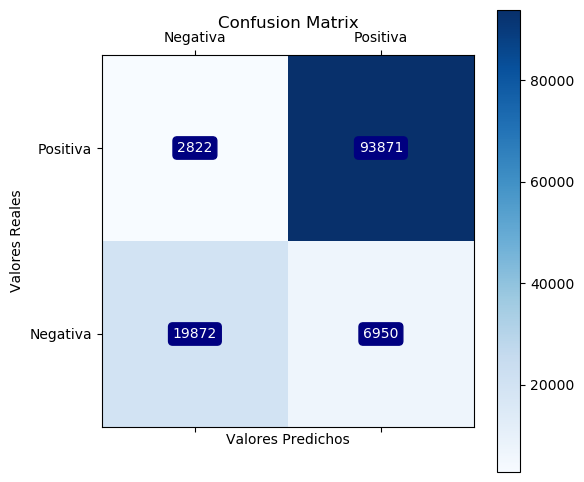

In [78]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(features_test)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 6))

cax = ax.matshow(cm, cmap='Blues')

for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, value, ha='center', va='center', color='white',
            bbox=dict(facecolor='navy', edgecolor='navy', boxstyle='round,pad=0.3'))

ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))

ax.set_xticklabels(['Negativa', 'Positiva'])
ax.set_yticklabels(['Negativa', 'Positiva'])

ax.invert_yaxis()

fig.colorbar(cax)

plt.xlabel('Valores Predichos')
plt.ylabel('Valores Reales')
plt.title('Confusion Matrix')
plt.show()

# Capturas de Pantalla del registro en MLFLOW

In [91]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

La primera captura consiste en el registro de todos los modelos entrenando cambiando los hiperparámetros

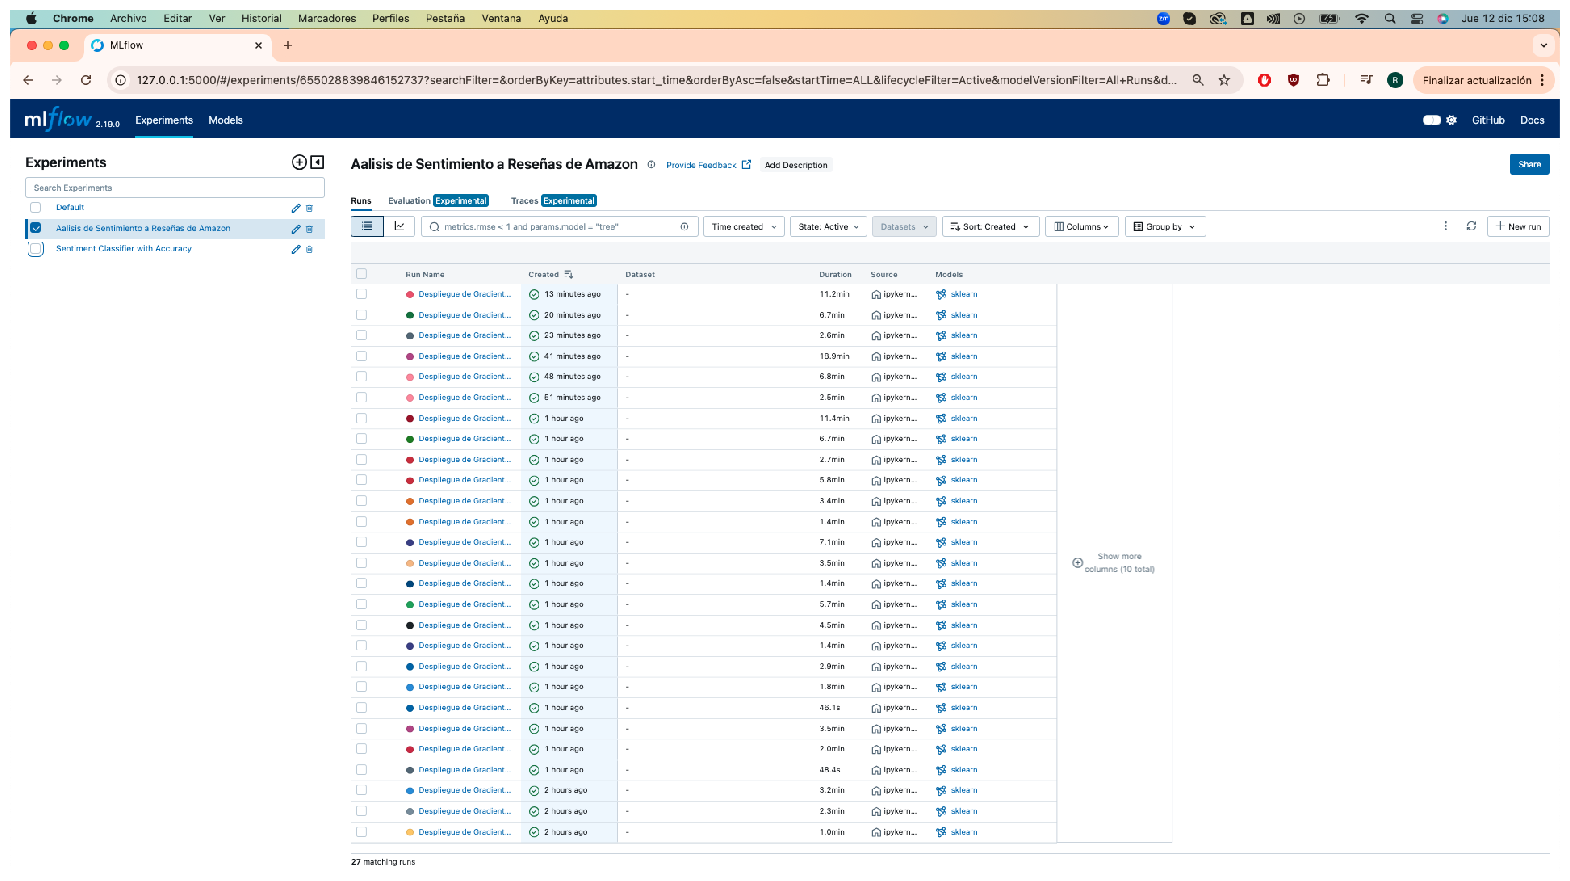

In [92]:
img = mpimg.imread(r'/Users/ralamo/Documents/Keepcoding/IA/Despliegue de Algoritmos/practica-despliegue-algoritmos/images/Búsqueda de Hiperparametros.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

Las siguientes capturas corresponden con el modelo final (en un experimento a parte) escogido posteriormente al entrenamiento. Muestro el overview, las metricas y el modelo

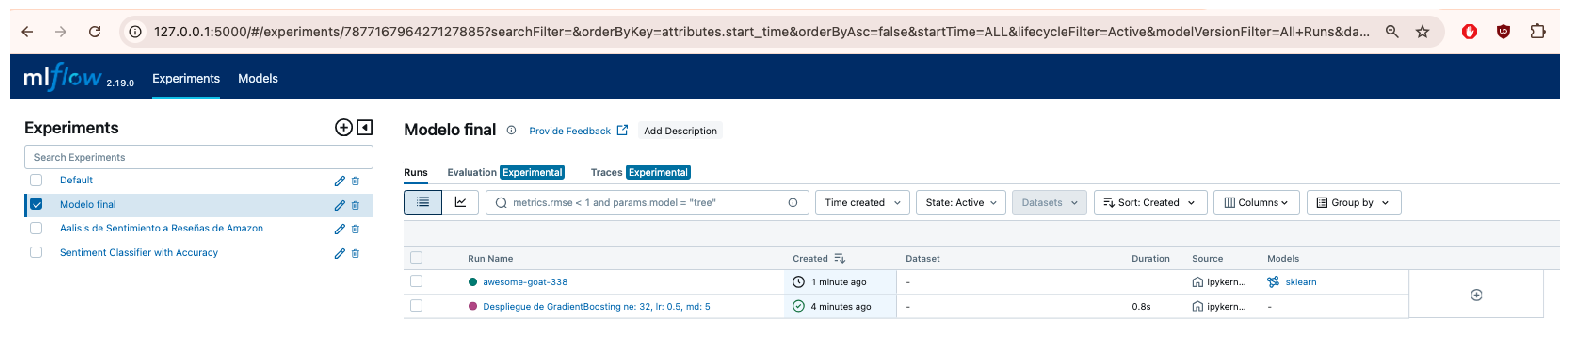

In [98]:
img = mpimg.imread(r'/Users/ralamo/Documents/Keepcoding/IA/Despliegue de Algoritmos/practica-despliegue-algoritmos/images/Modelo Final.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

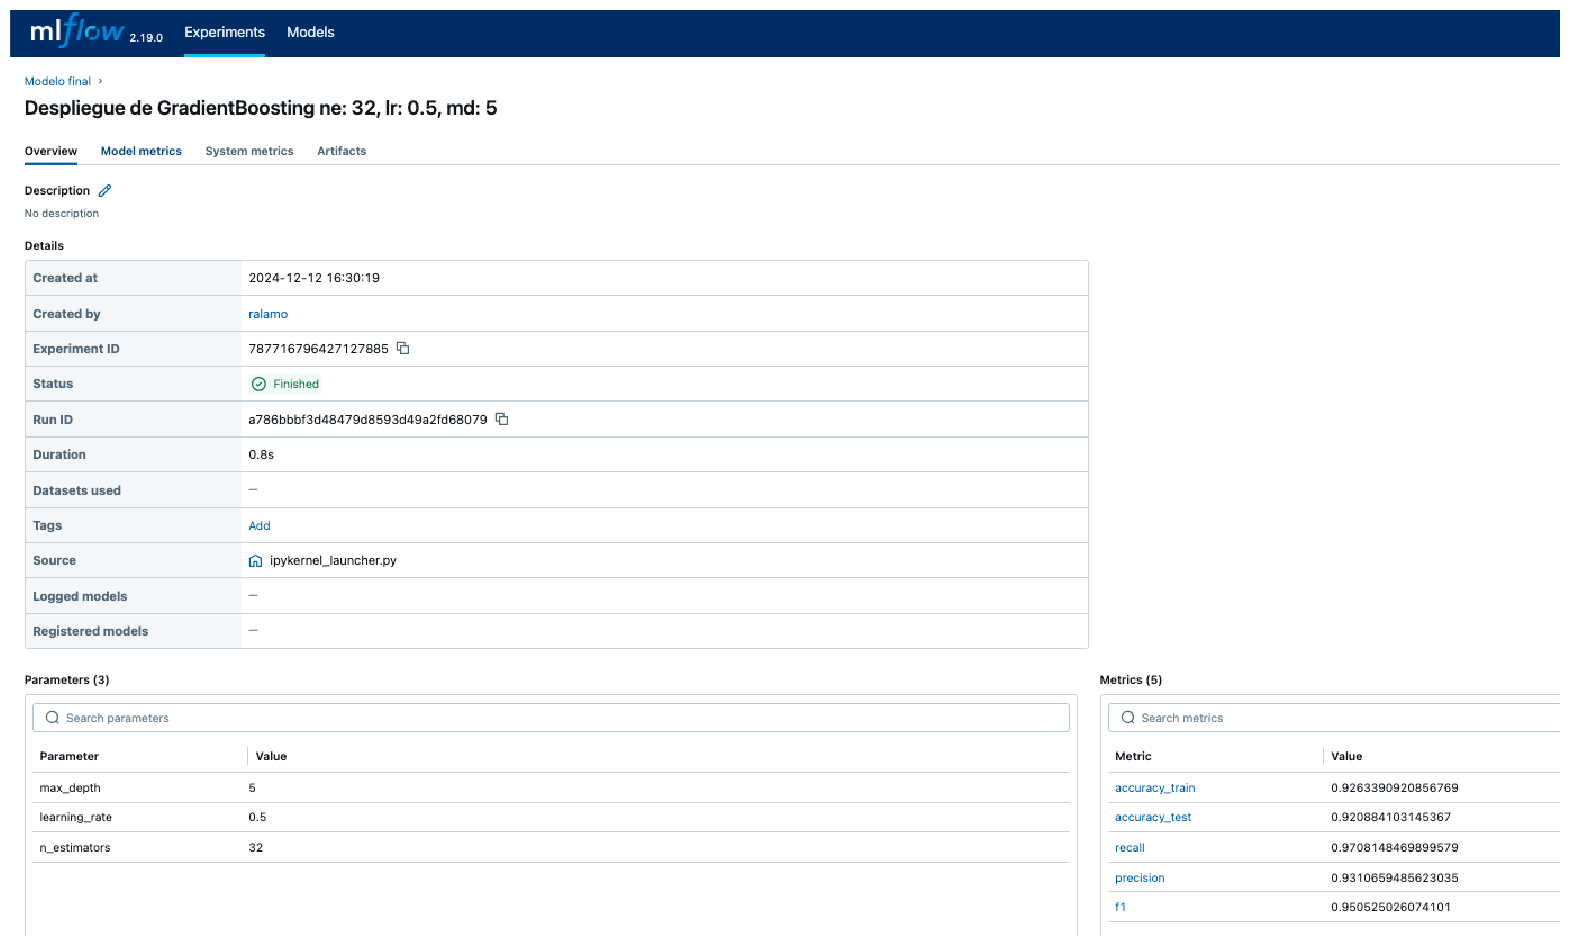

In [95]:
img = mpimg.imread(r'/Users/ralamo/Documents/Keepcoding/IA/Despliegue de Algoritmos/practica-despliegue-algoritmos/images/MF Overview.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

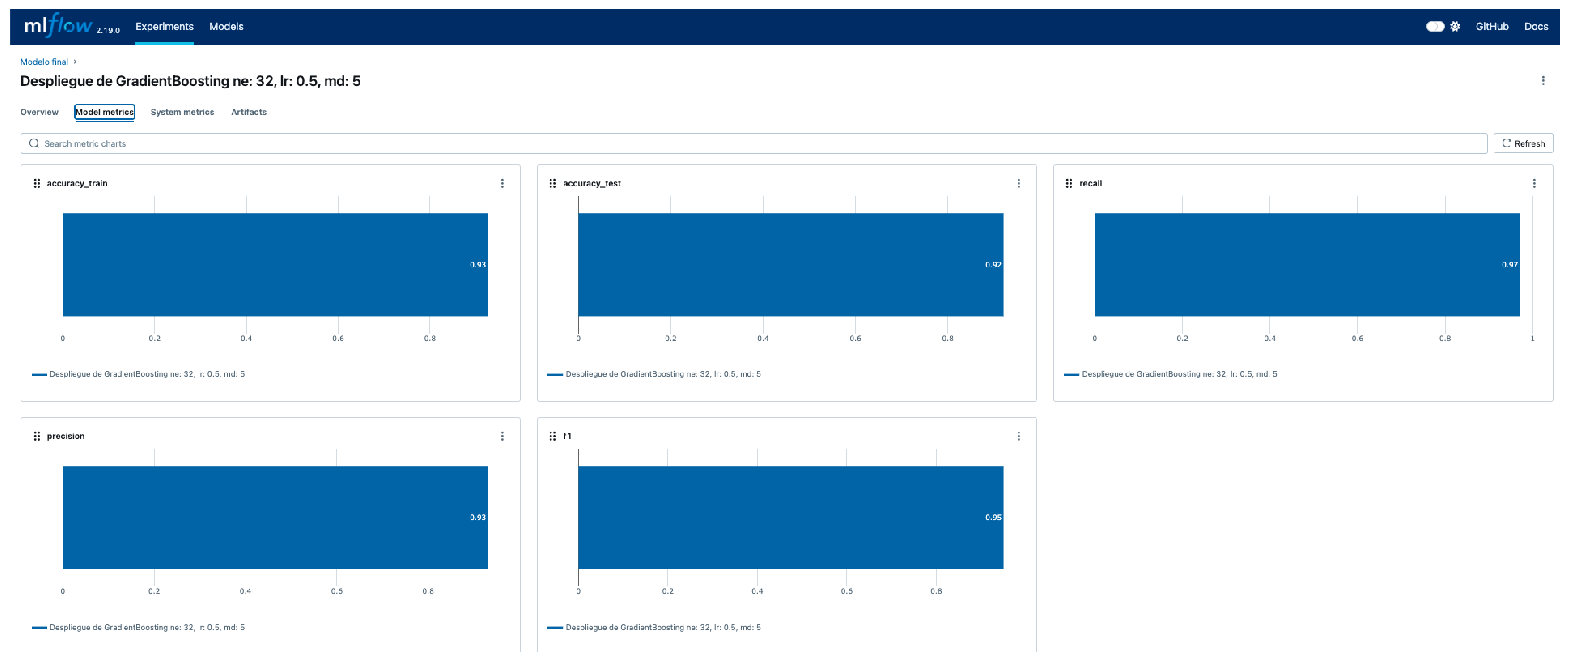

In [94]:
img = mpimg.imread(r'/Users/ralamo/Documents/Keepcoding/IA/Despliegue de Algoritmos/practica-despliegue-algoritmos/images/MF Metrics.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

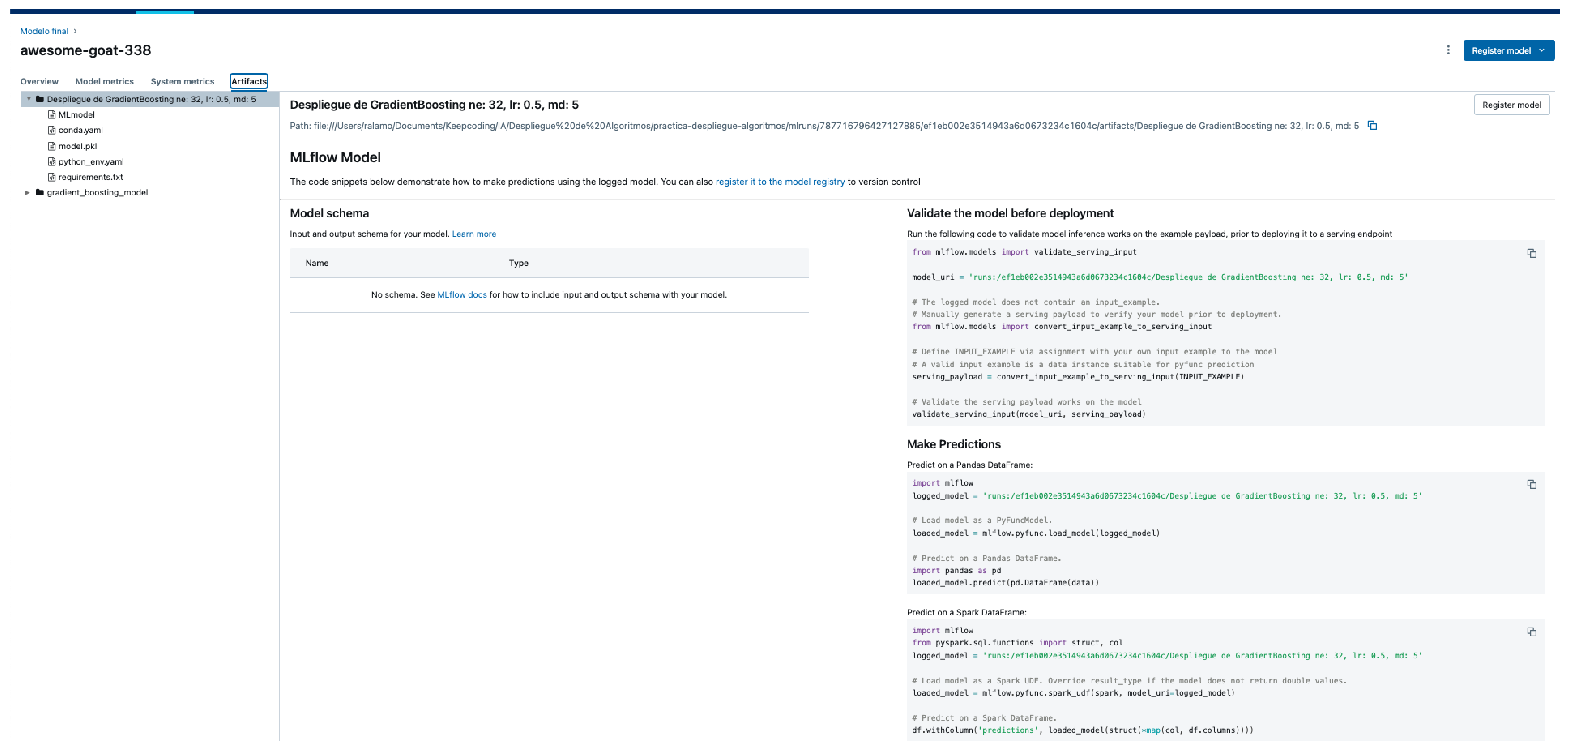

In [96]:
img = mpimg.imread(r'/Users/ralamo/Documents/Keepcoding/IA/Despliegue de Algoritmos/practica-despliegue-algoritmos/images/MF Modelo.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

La última captura corresponde con el registro del modelo final

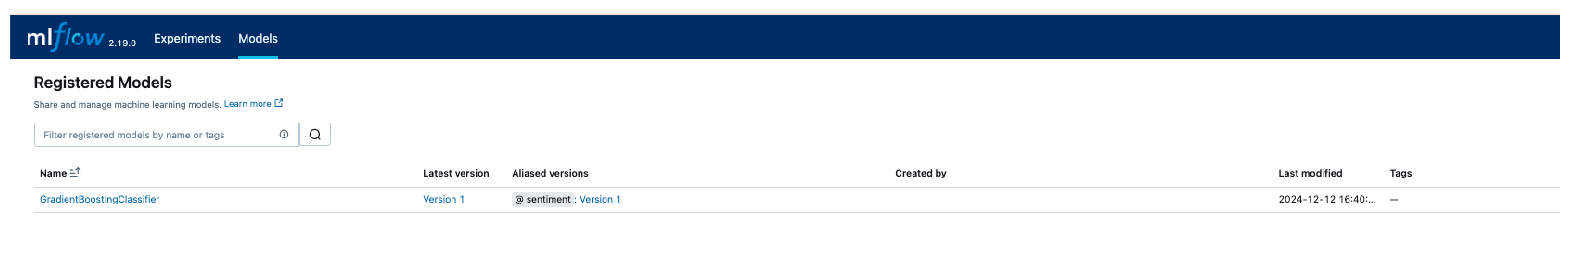

In [99]:
img = mpimg.imread(r'/Users/ralamo/Documents/Keepcoding/IA/Despliegue de Algoritmos/practica-despliegue-algoritmos/images/Registro.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()